In [58]:
%matplotlib inline
import my_functions as mf
import numpy as np
import matplotlib.pyplot as plt
import HLZ_recoil_fit as HLZ
import h5py
speed_of_light = 299792.458
path = '../Data/012/Lev5/' #path for the simulation
extrapolation_order = 2

alm = []
H2 = []

input_file1 = h5py.File(path+'rhOverM_Asymptotic_GeometricUnits.h5','r')
SXS = input_file1['Extrapolated_N%i.dir'%(extrapolation_order)]['Y_l%i_m%i.dat'%(2,-1)]
t = SXS[:,0]
dt = np.diff(t)

def ALM(l,m):
    #print("lol",l,m)
    if m>l or m<-l or l<2 or l>8:
        return 0
    return alm[l-2][m+l]
def Hcomp(l,m):
    if m>l or m<-l or l<2 or l>8:
        return 0
    return H2[l-2][m+l]
def norm(vector):
    return np.sqrt(vector[0]*vector[0]+vector[1]*vector[1]+vector[2]*vector[2])

meta = open(path+'metadata.txt','r')
for line in meta:
    line = line.translate(None,",")
    line = line.split()
    if(len(line)<2):
        continue;
    var = line[0].translate(None," ")
    if var == 'initial-ADM-energy':
        initial_mass = float(line[2])
    #if var == 'initial-ADM-linear-momentum':
        #initial_p = np.array([float(line[2]),float(line[3]),float(line[4])])
    #if var == 'initial-ADM-angular-momentum':
    #    initial_j = np.array([float(line[2]),float(line[3]),float(line[4])])
    if var == 'remnant-mass':
        remnant_mass = float(line[2])
    if var == 'remnant-spin':
        remnant_spin = np.array([float(line[2]),float(line[3]),float(line[4])])
    if var == 'initial-mass1':
        initial_mass1 = float(line[2])
    if var == 'initial-mass2':
        initial_mass2 = float(line[2])
    if var == 'initial-spin1':
        initial_spin1 = np.array([float(line[2]),float(line[3]),float(line[4])])
    if var == 'initial-spin2':
        initial_spin2 = np.array([float(line[2]),float(line[3]),float(line[4])])
    
        
#The following are coefficients used in calculations of radiated angular and linear momentum       
def f(l,m):
    return np.sqrt((l-m)*(l+m+1))
def a(l,m):
    return np.sqrt((1.0+0j)*(l-m)*(l+m+1.0))/(l*(l+1.0))
def b(l,m):
    return (np.sqrt((1+0j)*(l-2.0)*(l+2.0)*(l+m)*(l+m-1.0)/(2.0*l-1.0)/(2.0*l+1.0)))/(2.0*l)
def c(l,m):
    return 2.0*m/(l*(l+1.0))
def d(l,m):
    return (np.sqrt((1.0+0j)*(l-2.0)*(l+2.0)*(l-m)*(l+m)/(2.0*l-1.0)/(2.0*l+1)))/l

#Calculates the H and Hdots to be used for further analysis.
for l in range(2,9):
    alm.append([])
    H2.append([])
    for m in range(-l,l+1):
        SXS = input_file1['Extrapolated_N2.dir']['Y_l%i_m%i.dat'%(l,m)]
        H = SXS[:,1]+(0+1j)*SXS[:,2]
        t = SXS[:,0]
        Hdot = np.diff(H)/np.diff(t)
        alm[l-2].append(Hdot)
        H2[l-2].append(H[1:])     
    

    

In [59]:
dp_plus = (0+0j)*(dt)
dp_z = dp_plus
for l in range(2,9):
    for m in range(-l,l+1):
        dp_plus = dp_plus+ALM(l,m)*(a(l,m)*np.conj(ALM(l,m+1)) + b(l,-m)*np.conj(ALM(l-1,m+1)) - b(l+1,m+1)*np.conj(ALM(l+1,m+1)))
        dp_z = dp_z + ALM(l,m)*(c(l,m)*np.conj(ALM(l,m)) + d(l,m)*np.conj(ALM(l-1,m)) + d(l+1,m)*np.conj(ALM(l+1,m)))
p_plus = np.cumsum(dp_plus*dt)/(8*np.pi)
PZ = np.real(np.cumsum(dp_z*dt)/(16*np.pi))
PX = np.real(p_plus)
PY = np.imag(p_plus)
P = np.array([PX,PY,PZ])
Total_P = norm(P)
Radiated_P = np.array([PX[-1],PY[-1],PZ[-1]])
Total_Radiated_P = norm(Radiated_P)
Kick = -1 * Radiated_P/remnant_mass * speed_of_light
Total_Kick = norm(Kick) 

Mass Ratio: 1.50000000021
Initial Spin1: [ -4.06800000e-15  -2.88000000e-15  -1.80000000e-01]
Initial Spin2: [  3.43200000e-14   1.65440000e-14   3.33785952e-10]
Final Kick of Blackhole Calculated : [  2.32211682e+02  -3.98578756e+01   3.82068988e-05]
Final Speed of the Blackhole: 235.607545883 km/s
Final Speed from the Fit: 237.309929767 km/s
Error: 0.717367320467%


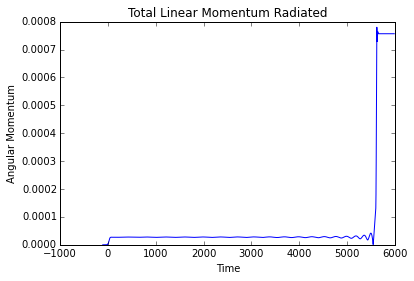

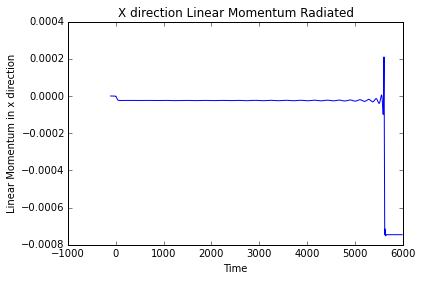

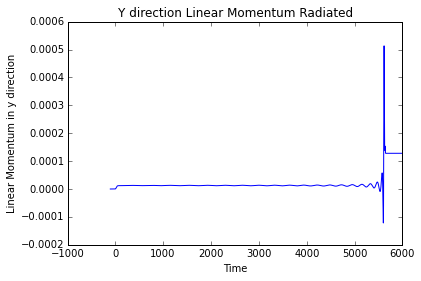

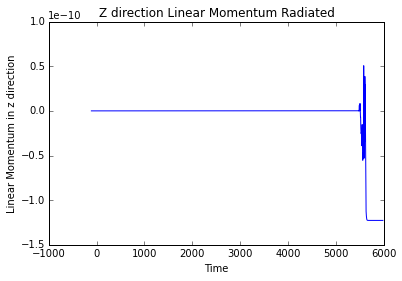

In [60]:
dless_spin1 = initial_spin1[2]/(initial_mass1**2)
dless_spin2 = initial_spin2[2]/(initial_mass2**2)
q = initial_mass1/initial_mass2
fit_kick = HLZ.bbh_recoil_HLZ_aligned(q,dless_spin1,dless_spin2)
print("Mass Ratio: {}".format(initial_mass1/initial_mass2))
print("Initial Spin1: {}".format(initial_spin1))
print("Initial Spin2: {}".format(initial_spin2))
print("Final Kick of Blackhole Calculated : {}".format(Kick))
print("Final Speed of the Blackhole: {} km/s".format(Total_Kick))
print("Final Speed from the Fit: {} km/s".format(fit_kick))
print("Error: {}%".format(mf.error(fit_kick,Total_Kick)))

plt.figure(1)
plt.title("Total Linear Momentum Radiated")
plt.xlabel("Time")
plt.ylabel("Angular Momentum")
plt.plot(t[1:],Total_P)
plt.show()

plt.figure(2)
plt.title("X direction Linear Momentum Radiated")
plt.xlabel("Time")
plt.ylabel("Linear Momentum in x direction")
plt.plot(t[1:],P[0])
plt.show()

plt.figure(3)
plt.title("Y direction Linear Momentum Radiated")
plt.xlabel("Time")
plt.ylabel("Linear Momentum in y direction")
plt.plot(t[1:],P[1])
plt.show()

plt.figure(4)
plt.title("Z direction Linear Momentum Radiated")
plt.xlabel("Time")
plt.ylabel("Linear Momentum in z direction")
plt.plot(t[1:],P[2])
plt.show()



